In [37]:
import kagglehub
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.


In [2]:
color_path = os.path.join(path, 'plantvillage dataset', 'color')

target_dir = '/content/potato_data'
os.makedirs(target_dir, exist_ok=True)

potato_folders = [f for f in os.listdir(color_path) if 'Potato' in f]

for folder in potato_folders:
    source = os.path.join(color_path, folder)
    destination = os.path.join(target_dir, folder)
    if not os.path.exists(destination):
        shutil.copytree(source, destination)
        print(f"Selected and copied: {folder}")

print(f"\nFinished! Your selected data is now in: {target_dir}")

Selected and copied: Potato___healthy
Selected and copied: Potato___Early_blight
Selected and copied: Potato___Late_blight

Finished! Your selected data is now in: /content/potato_data


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# Load the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    target_dir,
    shuffle=True, # For reproducibility
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
# Get class names
class_names = dataset.class_names
print(f"Class names: {class_names}")

Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset)

68

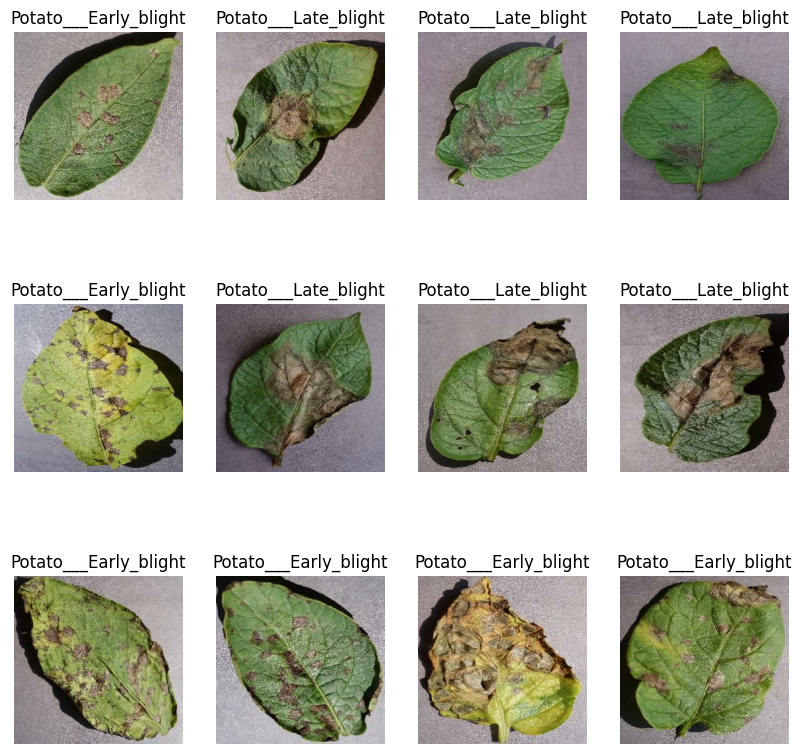

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [10]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
print(f"Total batches: {len(dataset)}")
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Total batches: 68
Training batches: 54
Validation batches: 6
Test batches: 8


In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [19]:
# 1. Define the input shape
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# 2. Build the model architecture
model = models.Sequential([
    # Apply Resizing and Rescaling first
    resize_and_rescale,

    # Apply Data Augmentation (only runs during training)
    data_augmentation,

    # First Convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fifth Convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Sixth Convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Final Dense Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# 1. Compile: Setting the 'Learning Rules'
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
# 2. Fit: The actual training (The model starts studying the leaves)
# We will run for 20 epochs (rounds of study)
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.4910 - loss: 0.9257 - val_accuracy: 0.5365 - val_loss: 0.8950
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6538 - loss: 0.8078 - val_accuracy: 0.7917 - val_loss: 0.4576
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8372 - loss: 0.4006 - val_accuracy: 0.9010 - val_loss: 0.3250
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8920 - loss: 0.2739 - val_accuracy: 0.9219 - val_loss: 0.2322
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9111 - loss: 0.2116 - val_accuracy: 0.9219 - val_loss: 0.1735
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9092 - loss: 0.2034 - val_accuracy: 0.9167 - val_loss: 0.1681
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9452 - loss: 0.1338 - val_accuracy: 0.9323 - val_loss: 0.1896
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9613 - loss: 0.1253 - val_accuracy: 0.9323 -

In [22]:
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9482 - loss: 0.1397
Test Accuracy: 94.53%


**Plotting the Accuracy and Loss Curves**

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
type(history.history['loss'])

list

In [27]:
len(history.history['loss'])

20

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9192005395889282,
 0.7060851454734802,
 0.36216485500335693,
 0.2768096625804901,
 0.23093467950820923]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

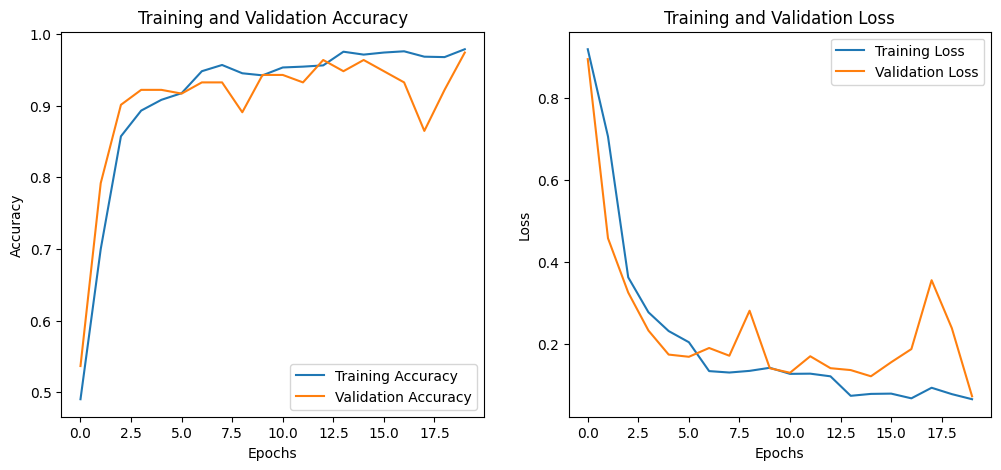

In [30]:
# Use the actual number of epochs recorded in history
actual_epochs = len(history.history['accuracy'])

plt.figure(figsize=(12, 5)) # Made slightly wider for better visibility

# 1. Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(actual_epochs), acc, label='Training Accuracy')
plt.plot(range(actual_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# 2. Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(actual_epochs), loss, label='Training Loss')
plt.plot(range(actual_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

**Run prediction on a sample image**

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
predicted label: Potato___Early_blight


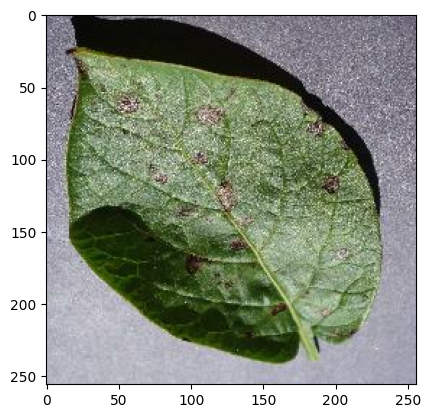

In [39]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


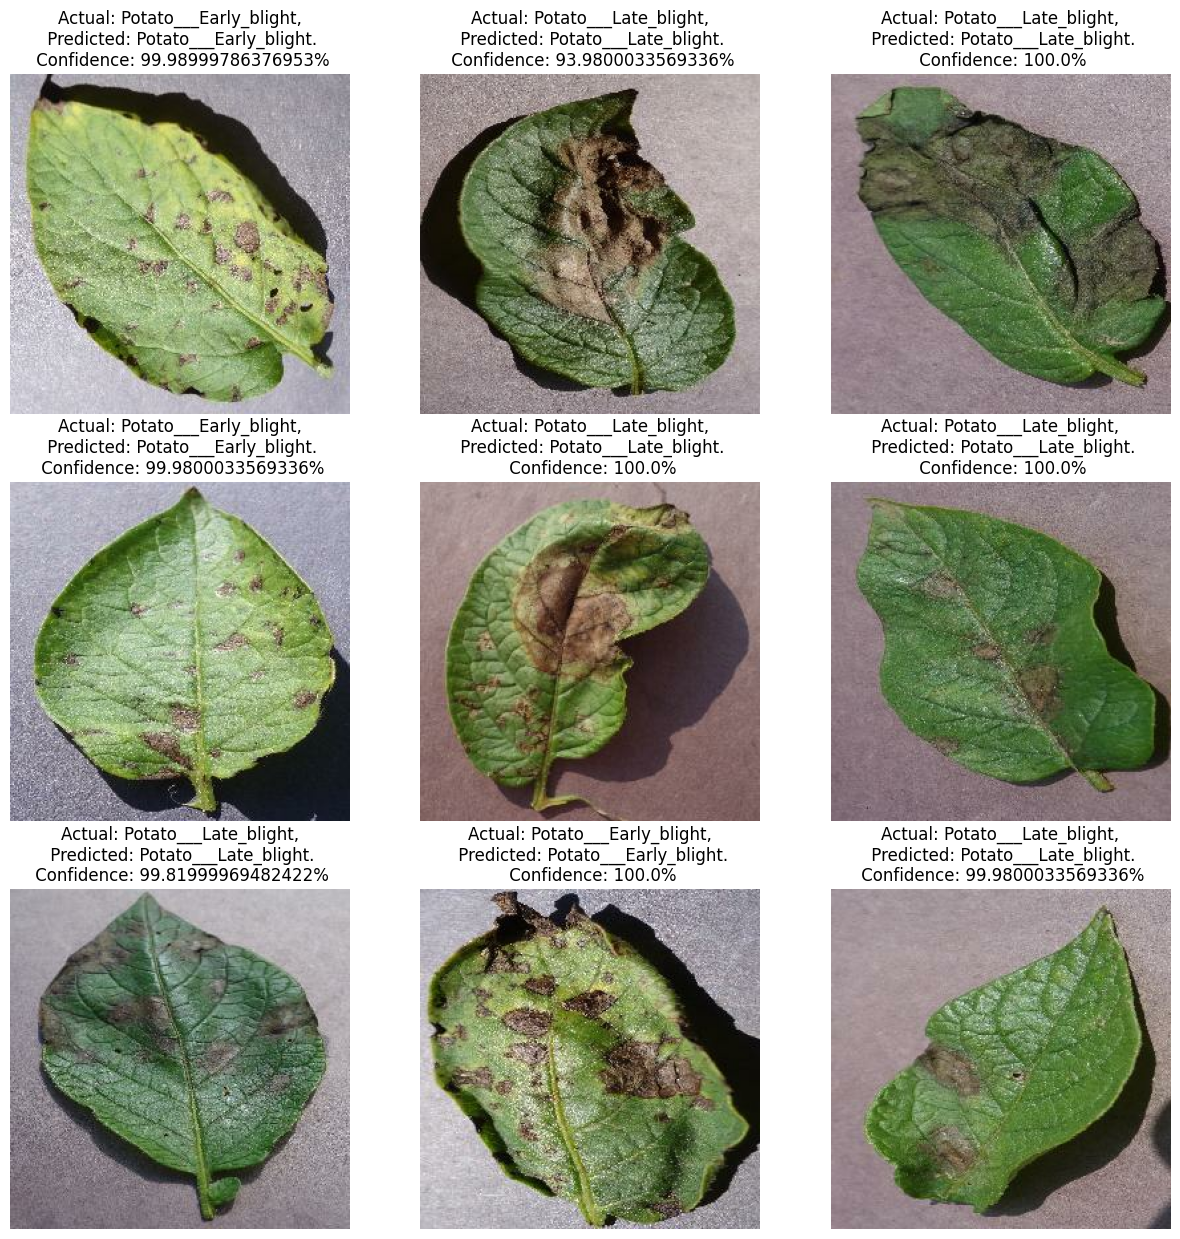

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [34]:
model.save("potato_model.keras")

from google.colab import files
files.download("potato_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>